In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [12]:
# 0. Setup
WORK_DIR = os.curdir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# 1. Diffusion parameters
T = 200
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

In [14]:
# 2. Model
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t):
        t = t[:, None, None, None].float() / T
        t_embed = t.expand_as(x)
        x = torch.cat([x, t_embed], dim=1)
        return self.net(x[:, :1])


# 3. Forward diffusion q(x_t | x_0)
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - alphas_cumprod[t])[
        :, None, None, None
    ]
    return sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise

In [15]:
# 4. Dataset
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x * 2) - 1])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [16]:
# 5. Train
model = DiffusionModel().to(device)
model = torch.nn.DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    for x0, _ in tqdm(dataloader):
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise)
        pred_noise = model(xt, t)

        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch done {epoch} — Loss: {loss.item():.4f}")

100%|██████████| 235/235 [00:10<00:00, 22.70it/s]


Epoch done 0 — Loss: 0.1510


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


Epoch done 1 — Loss: 0.1208


100%|██████████| 235/235 [00:10<00:00, 22.75it/s]


Epoch done 2 — Loss: 0.1306


100%|██████████| 235/235 [00:10<00:00, 22.69it/s]


Epoch done 3 — Loss: 0.1340


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 4 — Loss: 0.1121


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 5 — Loss: 0.1244


100%|██████████| 235/235 [00:10<00:00, 22.44it/s]


Epoch done 6 — Loss: 0.1217


100%|██████████| 235/235 [00:10<00:00, 22.41it/s]


Epoch done 7 — Loss: 0.1052


100%|██████████| 235/235 [00:10<00:00, 22.61it/s]


Epoch done 8 — Loss: 0.1168


100%|██████████| 235/235 [00:10<00:00, 22.71it/s]


Epoch done 9 — Loss: 0.0995


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 10 — Loss: 0.0977


100%|██████████| 235/235 [00:10<00:00, 22.71it/s]


Epoch done 11 — Loss: 0.0953


100%|██████████| 235/235 [00:10<00:00, 22.67it/s]


Epoch done 12 — Loss: 0.1193


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 13 — Loss: 0.1181


100%|██████████| 235/235 [00:10<00:00, 22.35it/s]


Epoch done 14 — Loss: 0.1020


100%|██████████| 235/235 [00:10<00:00, 22.40it/s]


Epoch done 15 — Loss: 0.1022


100%|██████████| 235/235 [00:10<00:00, 22.67it/s]


Epoch done 16 — Loss: 0.0983


100%|██████████| 235/235 [00:10<00:00, 22.65it/s]


Epoch done 17 — Loss: 0.1152


100%|██████████| 235/235 [00:10<00:00, 22.73it/s]


Epoch done 18 — Loss: 0.0969


100%|██████████| 235/235 [00:10<00:00, 22.42it/s]


Epoch done 19 — Loss: 0.0968


100%|██████████| 235/235 [00:10<00:00, 22.70it/s]


Epoch done 20 — Loss: 0.1001


100%|██████████| 235/235 [00:10<00:00, 22.54it/s]


Epoch done 21 — Loss: 0.1126


100%|██████████| 235/235 [00:10<00:00, 22.77it/s]


Epoch done 22 — Loss: 0.0953


100%|██████████| 235/235 [00:10<00:00, 22.64it/s]


Epoch done 23 — Loss: 0.0963


100%|██████████| 235/235 [00:10<00:00, 22.47it/s]


Epoch done 24 — Loss: 0.0894


100%|██████████| 235/235 [00:10<00:00, 22.80it/s]


Epoch done 25 — Loss: 0.0955


100%|██████████| 235/235 [00:10<00:00, 22.79it/s]


Epoch done 26 — Loss: 0.0936


100%|██████████| 235/235 [00:10<00:00, 22.81it/s]


Epoch done 27 — Loss: 0.0899


100%|██████████| 235/235 [00:10<00:00, 22.80it/s]


Epoch done 28 — Loss: 0.0960


100%|██████████| 235/235 [00:10<00:00, 22.58it/s]


Epoch done 29 — Loss: 0.0959


100%|██████████| 235/235 [00:10<00:00, 22.74it/s]


Epoch done 30 — Loss: 0.0976


100%|██████████| 235/235 [00:10<00:00, 22.72it/s]


Epoch done 31 — Loss: 0.1084


100%|██████████| 235/235 [00:10<00:00, 22.56it/s]


Epoch done 32 — Loss: 0.0938


100%|██████████| 235/235 [00:10<00:00, 22.65it/s]


Epoch done 33 — Loss: 0.0979


100%|██████████| 235/235 [00:10<00:00, 22.64it/s]


Epoch done 34 — Loss: 0.0899


100%|██████████| 235/235 [00:10<00:00, 22.60it/s]


Epoch done 35 — Loss: 0.1030


100%|██████████| 235/235 [00:10<00:00, 22.64it/s]


Epoch done 36 — Loss: 0.1074


100%|██████████| 235/235 [00:10<00:00, 22.69it/s]


Epoch done 37 — Loss: 0.0892


100%|██████████| 235/235 [00:10<00:00, 22.49it/s]


Epoch done 38 — Loss: 0.0981


100%|██████████| 235/235 [00:10<00:00, 22.66it/s]


Epoch done 39 — Loss: 0.0896


100%|██████████| 235/235 [00:10<00:00, 22.72it/s]


Epoch done 40 — Loss: 0.0974


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


Epoch done 41 — Loss: 0.0889


100%|██████████| 235/235 [00:10<00:00, 22.63it/s]


Epoch done 42 — Loss: 0.0881


100%|██████████| 235/235 [00:10<00:00, 22.67it/s]


Epoch done 43 — Loss: 0.1026


100%|██████████| 235/235 [00:10<00:00, 22.62it/s]


Epoch done 44 — Loss: 0.0996


100%|██████████| 235/235 [00:10<00:00, 22.87it/s]


Epoch done 45 — Loss: 0.0893


100%|██████████| 235/235 [00:10<00:00, 22.80it/s]


Epoch done 46 — Loss: 0.0996


100%|██████████| 235/235 [00:10<00:00, 22.59it/s]


Epoch done 47 — Loss: 0.1051


100%|██████████| 235/235 [00:10<00:00, 22.74it/s]


Epoch done 48 — Loss: 0.0934


100%|██████████| 235/235 [00:10<00:00, 22.77it/s]


Epoch done 49 — Loss: 0.0963


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


Epoch done 50 — Loss: 0.0924


100%|██████████| 235/235 [00:10<00:00, 22.85it/s]


Epoch done 51 — Loss: 0.0919


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


Epoch done 52 — Loss: 0.0877


100%|██████████| 235/235 [00:10<00:00, 22.58it/s]


Epoch done 53 — Loss: 0.0932


100%|██████████| 235/235 [00:10<00:00, 22.52it/s]


Epoch done 54 — Loss: 0.0939


100%|██████████| 235/235 [00:10<00:00, 22.29it/s]


Epoch done 55 — Loss: 0.0909


100%|██████████| 235/235 [00:10<00:00, 22.47it/s]


Epoch done 56 — Loss: 0.0955


100%|██████████| 235/235 [00:10<00:00, 22.51it/s]


Epoch done 57 — Loss: 0.1046


100%|██████████| 235/235 [00:10<00:00, 22.82it/s]


Epoch done 58 — Loss: 0.0870


100%|██████████| 235/235 [00:10<00:00, 22.92it/s]


Epoch done 59 — Loss: 0.0968


100%|██████████| 235/235 [00:10<00:00, 22.60it/s]


Epoch done 60 — Loss: 0.0822


100%|██████████| 235/235 [00:10<00:00, 22.98it/s]


Epoch done 61 — Loss: 0.0823


100%|██████████| 235/235 [00:10<00:00, 22.56it/s]


Epoch done 62 — Loss: 0.1039


100%|██████████| 235/235 [00:10<00:00, 22.46it/s]


Epoch done 63 — Loss: 0.0947


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 64 — Loss: 0.0820


100%|██████████| 235/235 [00:10<00:00, 22.86it/s]


Epoch done 65 — Loss: 0.0867


100%|██████████| 235/235 [00:10<00:00, 22.74it/s]


Epoch done 66 — Loss: 0.0900


100%|██████████| 235/235 [00:10<00:00, 22.64it/s]


Epoch done 67 — Loss: 0.0932


100%|██████████| 235/235 [00:10<00:00, 22.70it/s]


Epoch done 68 — Loss: 0.0895


100%|██████████| 235/235 [00:10<00:00, 22.62it/s]


Epoch done 69 — Loss: 0.0885


100%|██████████| 235/235 [00:10<00:00, 22.84it/s]


Epoch done 70 — Loss: 0.0944


100%|██████████| 235/235 [00:10<00:00, 22.67it/s]


Epoch done 71 — Loss: 0.0873


100%|██████████| 235/235 [00:10<00:00, 22.63it/s]


Epoch done 72 — Loss: 0.0975


100%|██████████| 235/235 [00:10<00:00, 22.82it/s]


Epoch done 73 — Loss: 0.0968


100%|██████████| 235/235 [00:10<00:00, 22.63it/s]


Epoch done 74 — Loss: 0.0947


100%|██████████| 235/235 [00:10<00:00, 22.63it/s]


Epoch done 75 — Loss: 0.0930


100%|██████████| 235/235 [00:10<00:00, 22.65it/s]


Epoch done 76 — Loss: 0.1045


100%|██████████| 235/235 [00:10<00:00, 23.11it/s]


Epoch done 77 — Loss: 0.0931


100%|██████████| 235/235 [00:10<00:00, 22.72it/s]


Epoch done 78 — Loss: 0.0849


100%|██████████| 235/235 [00:10<00:00, 22.91it/s]


Epoch done 79 — Loss: 0.0900


100%|██████████| 235/235 [00:10<00:00, 22.77it/s]


Epoch done 80 — Loss: 0.0916


100%|██████████| 235/235 [00:10<00:00, 22.79it/s]


Epoch done 81 — Loss: 0.0915


100%|██████████| 235/235 [00:10<00:00, 22.24it/s]


Epoch done 82 — Loss: 0.0983


100%|██████████| 235/235 [00:10<00:00, 22.77it/s]


Epoch done 83 — Loss: 0.0832


100%|██████████| 235/235 [00:10<00:00, 22.78it/s]


Epoch done 84 — Loss: 0.0923


100%|██████████| 235/235 [00:10<00:00, 22.59it/s]


Epoch done 85 — Loss: 0.0855


100%|██████████| 235/235 [00:10<00:00, 22.81it/s]


Epoch done 86 — Loss: 0.0929


100%|██████████| 235/235 [00:10<00:00, 22.86it/s]


Epoch done 87 — Loss: 0.0904


100%|██████████| 235/235 [00:10<00:00, 22.69it/s]


Epoch done 88 — Loss: 0.0825


100%|██████████| 235/235 [00:10<00:00, 22.68it/s]


Epoch done 89 — Loss: 0.0841


100%|██████████| 235/235 [00:10<00:00, 22.60it/s]


Epoch done 90 — Loss: 0.0903


100%|██████████| 235/235 [00:10<00:00, 22.55it/s]


Epoch done 91 — Loss: 0.0931


100%|██████████| 235/235 [00:10<00:00, 22.80it/s]


Epoch done 92 — Loss: 0.0928


100%|██████████| 235/235 [00:10<00:00, 22.93it/s]


Epoch done 93 — Loss: 0.0921


100%|██████████| 235/235 [00:10<00:00, 22.64it/s]


Epoch done 94 — Loss: 0.0850


100%|██████████| 235/235 [00:10<00:00, 22.86it/s]


Epoch done 95 — Loss: 0.1037


100%|██████████| 235/235 [00:10<00:00, 22.73it/s]


Epoch done 96 — Loss: 0.0941


100%|██████████| 235/235 [00:10<00:00, 22.54it/s]


Epoch done 97 — Loss: 0.0881


100%|██████████| 235/235 [00:10<00:00, 22.57it/s]


Epoch done 98 — Loss: 0.0873


100%|██████████| 235/235 [00:10<00:00, 23.17it/s]

Epoch done 99 — Loss: 0.0978


In [17]:
torch.save(model.state_dict(), "simple_diffusion_model.pth")
print("✅ Model saved!")

✅ Model saved!


In [18]:
model = DiffusionModel().to(device)
model.load_state_dict(torch.load("simple_diffusion_model.pth", map_location=device))
model.eval()

RuntimeError: Error(s) in loading state_dict for DiffusionModel:
	Missing key(s) in state_dict: "net.0.weight", "net.0.bias", "net.2.weight", "net.2.bias", "net.4.weight", "net.4.bias". 
	Unexpected key(s) in state_dict: "module.net.0.weight", "module.net.0.bias", "module.net.2.weight", "module.net.2.bias", "module.net.4.weight", "module.net.4.bias". 

In [ ]:
@torch.no_grad()
def p_sample_loop(model, shape):
    x = torch.randn(shape).to(device)  # start from pure noise

    for t in reversed(range(T)):
        t_batch = torch.full((x.shape[0],), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_batch)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]

        # Predict x0 from xt and predicted noise
        x0_pred = (x - (1 - alpha_cumprod_t).sqrt() * pred_noise) / alpha_cumprod_t.sqrt()

        # Compute mean of posterior
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0
        x = alpha_t.sqrt() * x0_pred + (1 - alpha_t).sqrt() * noise

    return x

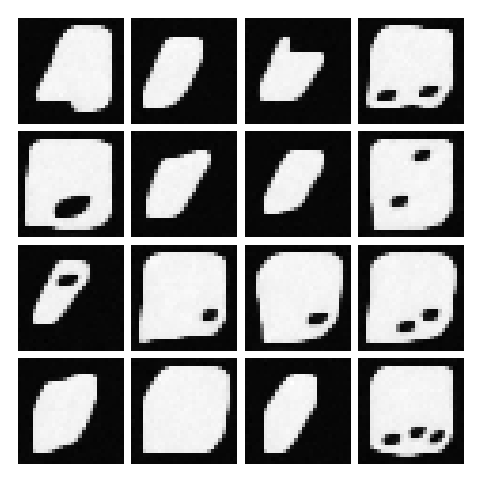

In [ ]:
samples = p_sample_loop(model, (16, 1, 28, 28))  # 16 samples, MNIST shape

import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True, pad_value=1)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()